In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import talib as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import math

In [2]:
data = pd.read_csv("BTC-USD.csv")
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-05,1254.290039,1267.290039,1238.060059,1267.119995,1267.119995,134127000.0
1,2017-03-06,1267.469971,1276.000000,1264.599976,1272.829956,1272.829956,153656992.0
2,2017-03-07,1273.209961,1275.550049,1204.800049,1223.540039,1223.540039,291256000.0
3,2017-03-08,1223.229980,1232.160034,1148.079956,1150.000000,1150.000000,332603008.0
4,2017-03-09,1150.349976,1197.459961,1141.229980,1188.489990,1188.489990,212283008.0
5,2017-03-10,1189.359985,1270.469971,1077.250000,1116.719971,1116.719971,563795968.0
6,2017-03-11,1116.319946,1193.829956,1116.319946,1175.829956,1175.829956,283320000.0
7,2017-03-12,1176.619995,1226.979980,1175.359985,1221.380005,1221.380005,227176000.0
8,2017-03-13,1221.780029,1237.369995,1217.030029,1231.920044,1231.920044,380276992.0
9,2017-03-14,1232.160034,1244.810059,1220.719971,1240.000000,1240.000000,245306000.0


In [3]:
close_prices = data["Close"]
vec1 = [1]*len(close_prices)
vec2 = [1]*len(close_prices)
for i in range(1,len(close_prices)):
    vec1[i] = (close_prices[i]/close_prices[i-1])
    vec2[i] = vec1[i]-vec1[i-1]

In [4]:
vec2 = list(vec2)
for i in range(1,1827):
    if vec2[i] >= 0.01:
        vec2[i] = "A"
    elif vec2[i] <= -0.01:
        vec2[i] = "C"
    else:
        vec2[i] = "B"
vec2.remove(1)

In [5]:
print("Number of A: " + str(vec2.count("A"))+"\nNumber of B: " + str(vec2.count("B"))+"\nNumber of C: " + str(vec2.count("C")))

Number of A: 712
Number of B: 367
Number of C: 747


In [6]:
print("Probability of A: " + str(round(vec2.count("A")/len(vec2),2))+"\nProbability of B: " + str(round(vec2.count("B")/len(vec2),2))+"\nProbability of C: " + str(round(vec2.count("C")/len(vec2),2)))

Probability of A: 0.39
Probability of B: 0.2
Probability of C: 0.41


In [7]:
df = pd.DataFrame(vec2)

df['shift'] = df[0].shift(-1)

df['count'] = 1

trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).values

In [12]:
trans_mat = pd.DataFrame(np.round(trans_mat,2))
trans_mat.rename(columns={0: 'A',1: 'B',2: 'C'}, index={0: 'A',1: 'B',2: 'C'}, inplace=True)
print(trans_mat)

      A     B     C
A  0.20  0.18  0.62
B  0.33  0.31  0.36
C  0.60  0.17  0.23


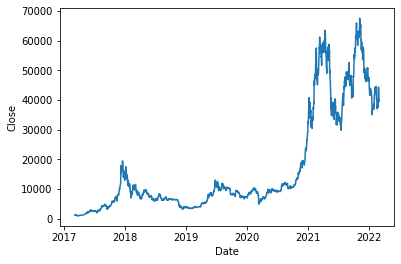

In [18]:
data["Date"] = pd.to_datetime(data["Date"])
sns.lineplot(x="Date",y="Close",data=data)
plt.show()

In [40]:
data.set_index("Date",inplace = True)

In [137]:
data1 = data[data.index > "2021-03-01"]

## Compute the technical indicators because it is fun :)

In [138]:
aroondown, aroonup = ta.AROON(data1["High"], data1["Low"], timeperiod=25)
aroon = ta.AROONOSC(data1["High"], data1["Low"], timeperiod=25)

In [139]:
slowk, slowd = ta.STOCH(data1["High"], data1["Low"], data1["Close"], fastk_period=14, slowk_period=3, slowk_matype=0, 
                        slowd_period=3, slowd_matype=0)
fastk, fastd = ta.STOCHF(data1["High"], data1["Low"], data1["Close"], fastk_period=14, fastd_period=3, fastd_matype=0)

In [140]:
chaikin = ta.ADOSC(data1["High"], data1["Low"], data1["Close"], data1["Volume"], fastperiod=3, slowperiod=10)

In [153]:
macd, macdsignal, macdhist = ta.MACD(data1["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

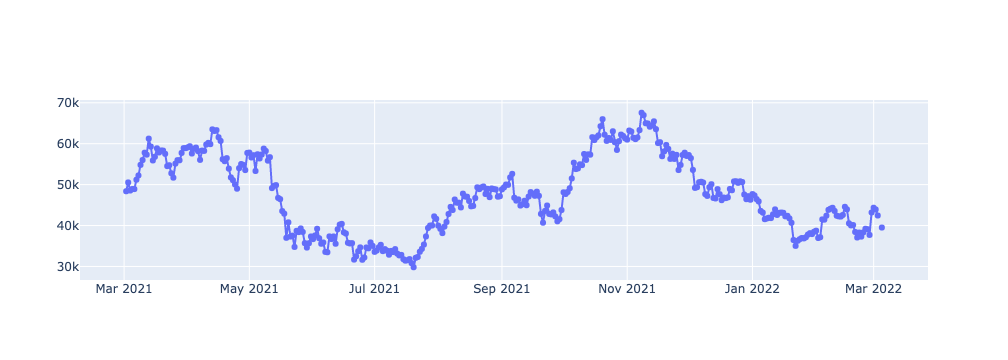

In [141]:
fig = go.Figure(data=go.Scatter(x=data1.index,y=data1['Close'], mode='lines+markers'))
fig.show()

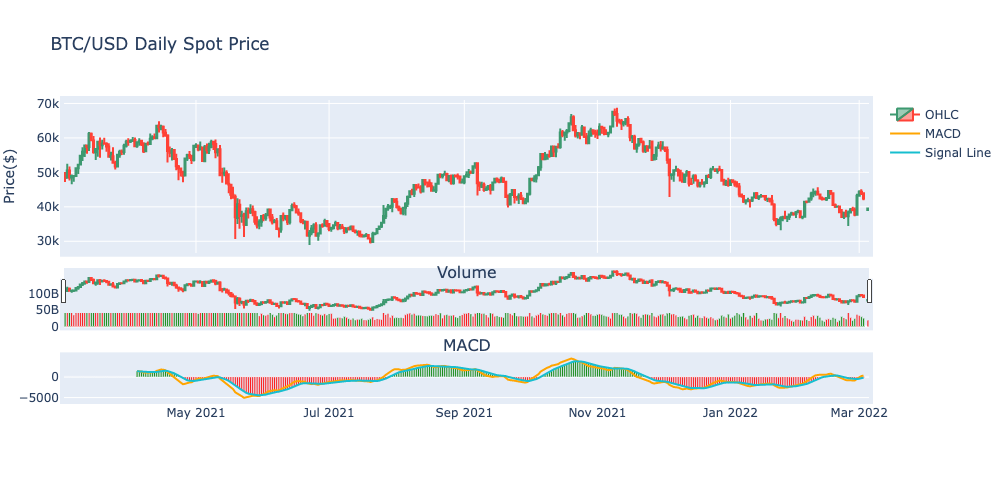

In [184]:
fig4 = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=("","Volume", "MACD"), 
               row_width=[0.2,0.2, 0.7])
fig4.add_trace(go.Candlestick(x=data1.index,
                              open=data1['Open'],
                              high=data1['High'],
                              low=data1['Low'],
                              close=data1['Close'],
                              name= "OHLC",showlegend=True),row=1, col=1)
fig4.add_trace(go.Line(x=data1.index, y=macd, marker_color='orange', showlegend=True, name= "MACD"), row=3, col=1)
fig4.add_trace(go.Line(x=data1.index, y=macdsignal, marker_color='#17becf', showlegend=True, name= "Signal Line"), row=3, col=1)

colors = ['green' if row['Open'] - row['Close'] >= 0 else 'red' for index, row in data1.iterrows()]
colors_hist = ['green' if macdsignal.fillna(0)[i] >= 0 else 'red' for i in macdsignal.index]

fig4.add_trace(go.Bar(x=data1.index, y=data1['Volume'],marker_color=colors,showlegend=False), row=2, col=1)
fig4.add_trace(go.Bar(x=data1.index, y=macdsignal.fillna(0),marker_color=colors_hist,showlegend=False), row=3, col=1)

fig4.update_layout(
    title='BTC/USD Daily Spot Price',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price($)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig4.update(layout_xaxis_rangeslider_visible=False)
fig4.show()

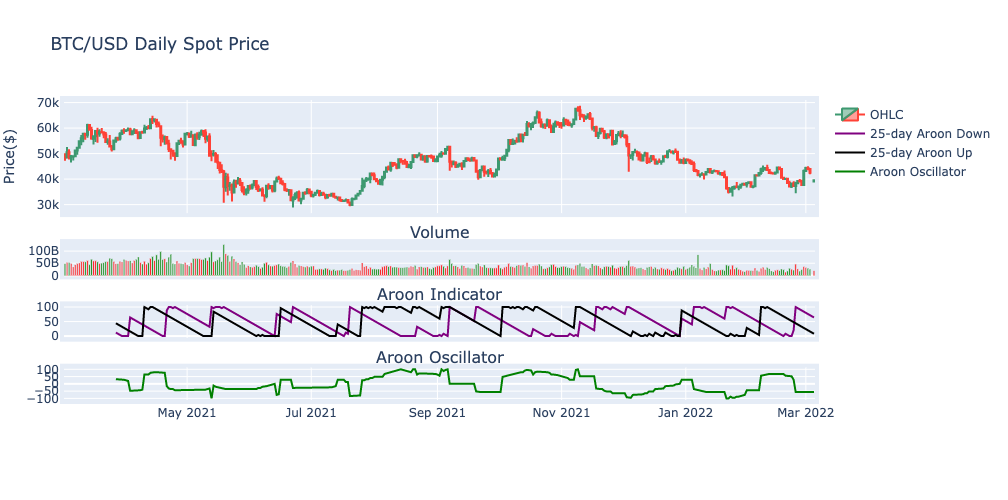

In [186]:
fig3 = make_subplots(rows=4, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=("","Volume", "Aroon Indicator", "Aroon Oscillator"), 
               row_width=[0.2,0.2,0.2, 0.7])
fig3.add_trace(go.Candlestick(x=data1.index,
                              open=data1['Open'],
                              high=data1['High'],
                              low=data1['Low'],
                              close=data1['Close'],
                              name= "OHLC",showlegend=True),row=1, col=1)
fig3.add_trace(go.Line(x=data1.index, y=aroondown, marker_color='purple', showlegend=True, name= "25-day Aroon Down"), row=3, col=1)
fig3.add_trace(go.Line(x=data1.index, y=aroonup, marker_color='black', showlegend=True, name= "25-day Aroon Up"), row=3, col=1)
fig3.add_trace(go.Line(x=data1.index, y=aroon, marker_color='green', showlegend=True, name= "Aroon Oscillator"), row=4, col=1)
colors = ['green' if row['Open'] - row['Close'] >= 0 
          else 'red' for index, row in data1.iterrows()]

fig3.add_trace(go.Bar(x=data1.index, y=data1['Volume'],marker_color=colors,showlegend=False), row=2, col=1)


fig3.update_layout(
    title='BTC/USD Daily Spot Price',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price($)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig3.update(layout_xaxis_rangeslider_visible=False)
fig3.show()

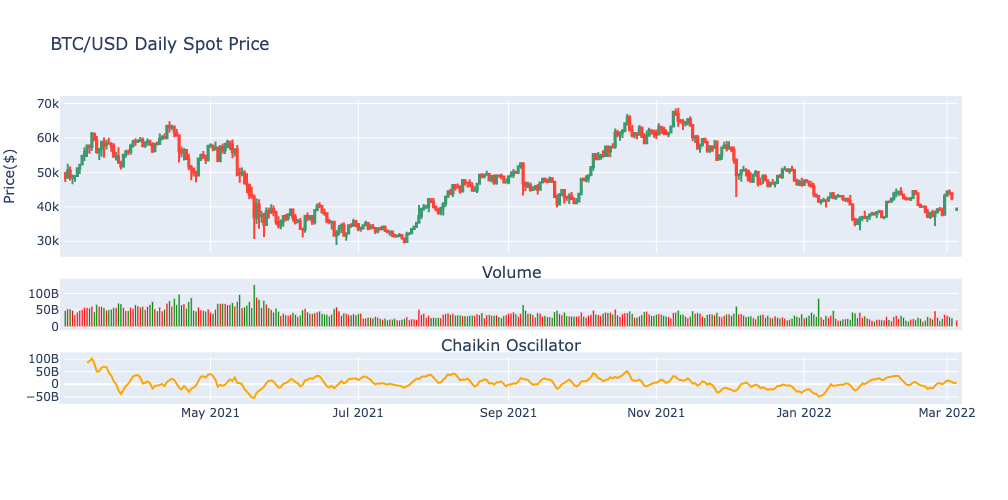

In [143]:
fig2 = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=("","Volume", "Chaikin Oscillator"), 
               row_width=[0.2, 0.2,0.7])
fig2.add_trace(go.Candlestick(x=data1.index,
                              open=data1['Open'],
                              high=data1['High'],
                              low=data1['Low'],
                              close=data1['Close'],
                              name= "OHLC",showlegend=False),row=1, col=1)
fig2.add_trace(go.Line(x=data1.index, y=chaikin, marker_color='orange', showlegend=False), row=3, col=1)

colors = ['green' if row['Open'] - row['Close'] >= 0 
          else 'red' for index, row in data1.iterrows()]

fig2.add_trace(go.Bar(x=data1.index, y=data1['Volume'],marker_color=colors,showlegend=False), row=2, col=1)

fig2.update_layout(
    title='BTC/USD Daily Spot Price',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price($)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig2.update(layout_xaxis_rangeslider_visible=False)
fig2.show()

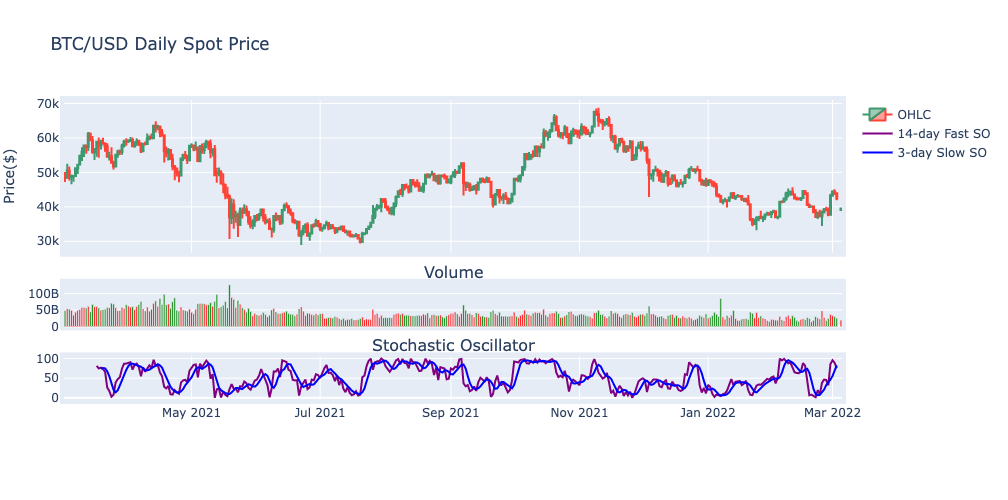

In [151]:
fig1 = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=("","Volume", "Stochastic Oscillator"), 
               row_width=[0.2, 0.2,0.7])
fig1.add_trace(go.Candlestick(x=data1.index,
                              open=data1['Open'],
                              high=data1['High'],
                              low=data1['Low'],
                              close=data1['Close'],
                              name= "OHLC",showlegend=True),row=1, col=1)
fig1.add_trace(go.Line(x=data1.index, y=fastk, marker_color='purple', showlegend=True, name= "14-day Fast SO"), row=3, col=1)
fig1.add_trace(go.Line(x=data1.index, y=slowd, marker_color='blue', showlegend=True, name= "3-day Slow SO"), row=3, col=1)

colors = ['green' if row['Open'] - row['Close'] >= 0 
          else 'red' for index, row in data1.iterrows()]

fig1.add_trace(go.Bar(x=data1.index, y=data1['Volume'],marker_color=colors,showlegend=False), row=2, col=1)



fig1.update_layout(
    title='BTC/USD Daily Spot Price',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price($)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig1.update(layout_xaxis_rangeslider_visible=False)
fig1.show()

In [206]:
data_returns = data['Close'].pct_change()

<AxesSubplot:xlabel='Close', ylabel='Count'>

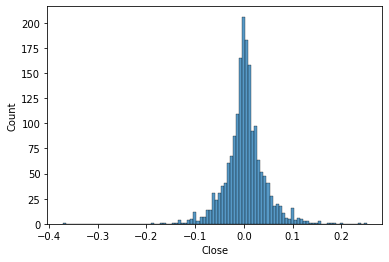

In [208]:
sns.histplot(x=data_returns,bins=100)

In [212]:
mean = data_returns.mean()
sigma = data_returns.var()

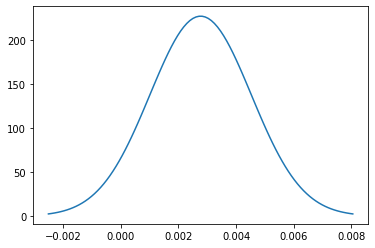

In [233]:
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
plt.plot(x,stats.norm.pdf(x, mean, sigma))
plt.xlabel = "Returns"
plt.ylabel = "Probability"
plt.show()